## Import libraries:

In [1]:
from imports import *

## 1. Preprocessing

The data corresponds to the Monte Carlo simulation of the SBND experiment. It was obtained by simulating the creation of neutrinos in the beam and their subsequent interaction in SBND, as well as the simulation of the detector's response to the particles resulting from the interaction of the neutrinos.

In [2]:
file_path = '/data/vidales/opana_tree_combined_v0411_both.root'
file = uproot.open(file_path)
optree = file['opanatree']['OpAnaTree'] # Tree con número de fotoelectrones
print("Keys in optree:", optree.keys())

Keys in optree: ['eventID', 'runID', 'subrunID', 'nuvX', 'nuvY', 'nuvZ', 'nuvT', 'nuvE', 'stepX', 'stepY', 'stepZ', 'stepT', 'dE', 'energydep', 'energydepX', 'energydepY', 'energydepZ', 'E', 'StartPx', 'StartPy', 'StartPz', 'EndPx', 'EndPy', 'EndPz', 'process', 'trackID', 'motherID', 'PDGcode', 'InTimeCosmics', 'InTimeCosmicsTime', 'dEtpc', 'dEpromx', 'dEpromy', 'dEpromz', 'dEspreadx', 'dEspready', 'dEspreadz', 'dElowedges', 'dEmaxedges', 'nopflash', 'flash_id', 'flash_time', 'flash_total_pe', 'flash_pe_v', 'flash_tpc', 'flash_y', 'flash_yerr', 'flash_z', 'flash_zerr', 'flash_x', 'flash_xerr', 'flash_ophit_time', 'flash_ophit_risetime', 'flash_ophit_starttime', 'flash_ophit_amp', 'flash_ophit_area', 'flash_ophit_width', 'flash_ophit_pe', 'flash_ophit_ch']


**Tarda 10min**

In [3]:
# Load variables to be predicted and associated data in a single step
nuvX, nuvZ, nuvT, f_ophit_PE, f_ophit_ch, f_ophit_t, flash_time, dEpromx, dEpromy, dEpromz, dEtpc = (optree[key].array() for key in ['nuvX','nuvZ', 'nuvT', 'flash_ophit_pe', 'flash_ophit_ch', 'flash_ophit_time', 'flash_time', 'dEpromx', 'dEpromy', 'dEpromz','dEtpc'])

In [4]:
print(nuvT[8315])
print((flash_time*1000)[8315])
print((f_ophit_t*1000)[8315])

[568]
[572, 580, 588]
[[8.59e+03, 8.58e+03, 8.54e+03, 8.53e+03, ..., 730, 730, 658, 642], ..., [...]]


**Filter events with more than one neutrino**

In [5]:
# Assuming all variables are awkward arrays
nuvX_1 = nuvX[ak.num(nuvT) == 1]
nuvZ_1 = nuvZ[ak.num(nuvT) == 1]
nuvT_1 = nuvT[ak.num(nuvT) == 1]
f_ophit_PE_1 = f_ophit_PE[ak.num(nuvT) == 1]
f_ophit_ch_1 = f_ophit_ch[ak.num(nuvT) == 1]
f_ophit_t_1 = f_ophit_t[ak.num(nuvT) == 1]
flash_time_1 = flash_time[ak.num(nuvT) == 1]
dEpromx_1 = dEpromx[ak.num(nuvT) == 1]
dEpromy_1 = dEpromy[ak.num(nuvT) == 1]
dEpromz_1 = dEpromz[ak.num(nuvT) == 1]
dEtpc_1 = dEtpc[ak.num(nuvT) == 1]

# Now all the variables are filtered and contain only subarrays with length 1 in nuvT.

In [8]:
print(nuvT[323])
print((flash_time*1000)[323])
print((f_ophit_t*1000)[323])

[1.84e+03]
[1.84e+03, 1.84e+03]
[[9.86e+03, 9.86e+03, 9.83e+03, 9.82e+03, ..., 2e+03, 2.01e+03, 2.01e+03], ...]


In [10]:
# Get the total length of the nuvX array
total_length = ak.sum(ak.num(nuvT_1))
print("Total number of elements in nuvT:", total_length)

Total number of elements in nuvT: 29582


**Filter events with no flash**

In [12]:
nuvX_2 = nuvX_1[ak.num(flash_time_1) != 0]
nuvZ_2 = nuvZ_1[ak.num(flash_time_1) != 0]
nuvT_2 = nuvT_1[ak.num(flash_time_1) != 0]
f_ophit_PE_2 = f_ophit_PE_1[ak.num(flash_time_1) != 0]
f_ophit_ch_2 = f_ophit_ch_1[ak.num(flash_time_1) != 0]
f_ophit_t_2 = f_ophit_t_1[ak.num(flash_time_1) != 0]
flash_time_2 = flash_time_1[ak.num(flash_time_1) != 0]
dEpromx_2 = dEpromx_1[ak.num(flash_time_1) != 0]
dEpromy_2 = dEpromy_1[ak.num(flash_time_1) != 0]
dEpromz_2 = dEpromz_1[ak.num(flash_time_1) != 0]
dEtpc_2 = dEtpc_1[ak.num(flash_time_1) != 0]

In [14]:
print(nuvT[523])
print((flash_time*1000)[523])
print((f_ophit_t*1000)[523])

[1.86e+03]
[1.87e+03, 1.89e+03, 1.87e+03]
[[9.9e+03, 9.87e+03, 9.79e+03, ..., 2.02e+03, 2.03e+03, 2.03e+03], ..., [...]]


In [15]:
# Get the total length of the nuvX array
total_length = ak.sum(ak.num(nuvT_2))
print("Total number of elements in dEpromx:", total_length)

Total number of elements in dEpromx: 28986


**Correction PMT delay 135 ns due to the difference between the photon arrival times (at the photocathode)
and the digitised signal (at the anode)**

In [16]:
PDSMap = file['opanatree']['PDSMapTree']
ID = PDSMap['OpDetID'].array()
Type = PDSMap['OpDetType'].array()
channel_dict = {id_val: (int(type_val)) for id_val, type_val in zip(ID[0],Type[0])}
print(channel_dict)

{0: 3, 1: 3, 2: 3, 3: 3, 4: 3, 5: 3, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 0, 18: 2, 19: 2, 20: 2, 21: 2, 22: 2, 23: 2, 24: 3, 25: 3, 26: 3, 27: 3, 28: 3, 29: 3, 30: 3, 31: 3, 32: 3, 33: 3, 34: 3, 35: 3, 36: 1, 37: 1, 38: 1, 39: 1, 40: 1, 41: 1, 42: 2, 43: 2, 44: 2, 45: 2, 46: 2, 47: 2, 48: 2, 49: 2, 50: 2, 51: 2, 52: 2, 53: 2, 54: 3, 55: 3, 56: 3, 57: 3, 58: 3, 59: 3, 60: 0, 61: 0, 62: 0, 63: 0, 64: 0, 65: 0, 66: 0, 67: 0, 68: 0, 69: 0, 70: 0, 71: 0, 72: 2, 73: 2, 74: 2, 75: 2, 76: 2, 77: 2, 78: 3, 79: 3, 80: 3, 81: 3, 82: 3, 83: 3, 84: 0, 85: 0, 86: 0, 87: 0, 88: 0, 89: 0, 90: 0, 91: 0, 92: 0, 93: 0, 94: 0, 95: 0, 96: 2, 97: 2, 98: 2, 99: 2, 100: 2, 101: 2, 102: 3, 103: 3, 104: 3, 105: 3, 106: 3, 107: 3, 108: 3, 109: 3, 110: 3, 111: 3, 112: 3, 113: 3, 114: 1, 115: 1, 116: 1, 117: 1, 118: 1, 119: 1, 120: 2, 121: 2, 122: 2, 123: 2, 124: 2, 125: 2, 126: 2, 127: 2, 128: 2, 129: 2, 130: 2, 131: 2, 132: 3, 133: 3, 134: 3, 135: 3, 136: 3, 137: 3, 138: 

In [17]:
# Convertimos el diccionario en un conjunto para los valores 0 y 1
channels_to_correct = [ch for ch, value in channel_dict.items() if value in {0, 1}]
print(channels_to_correct)
print(len(channels_to_correct))

[6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 36, 37, 38, 39, 40, 41, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 114, 115, 116, 117, 118, 119, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 192, 193, 194, 195, 196, 197, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 270, 271, 272, 273, 274, 275, 294, 295, 296, 297, 298, 299, 300, 301, 302, 303, 304, 305]
120


**It took six minutes in total**

In [20]:
# Crear una máscara que indique si cada elemento de f_ophit_ch está en channel_list
mask = ak.Array([
    [[ch in channels_to_correct for ch in ophit] for ophit in flash] for flash in f_ophit_ch_2
])

In [22]:
# Aplicar la máscara para ajustar f_ophit_t
f_ophit_t_adj = ak.where(mask, f_ophit_t_2 - 0.135, f_ophit_t_2)

**An interesting observation -> when the first ophit is True or False, the rest of the flash is the same as ophits from XAS and PMTs are different**

**Take only the dE where the neutrino is**

**Deberia cambiar el nombre de la variable a dEpromx_22**

In [ ]:
# Select first element if nuvX is negative, second element if nuvX is positive
dEpromx_2 = ak.where(nuvX_2 < 0, dEpromx_2[:, 0], dEpromx_2[:, 1])
dEpromy_2 = ak.where(nuvX_2 < 0, dEpromy_2[:, 0], dEpromy_2[:, 1])
dEpromz_2 = ak.where(nuvX_2 < 0, dEpromz_2[:, 0], dEpromz_2[:, 1])
dEtpc_2 = ak.where(nuvX_2 <0, dEtpc_2[:, 0], dEtpc_2[:, 1])
# Print the result
print("Selected elements:", dEpromx_2)
print("Length:", len(dEpromx_2))

**Eliminate useless values and interactions with deposition less than 200 MeV**

**Desaparecen la mitad de eventos por la cond. >200 MeV**

In [25]:
# Create a boolean mask where dEpromx_f_unique is not -999
# Also select events with deposition >200 MeV (dEtpc_f > 200)

mask = (dEpromx_2 != -999) & (dEpromy_2 != -999) & (dEpromz_2 != -999) & (dEtpc_2 > 100)
#mask = (dEpromx != -999) & (dEpromy != -999) & (dEpromz != -999)
mask_1d = ak.to_numpy(ak.flatten(mask))

# Apply the mask to both the image and dEpromx_f_unique to keep only the valid entries

nuvX_3 = nuvX_2[mask_1d]
nuvZ_3 = nuvZ_2[mask_1d]
nuvT_3 = nuvT_2[mask_1d]
f_ophit_PE_3 = f_ophit_PE_2[mask_1d]
f_ophit_ch_3 = f_ophit_ch_2[mask_1d]
f_ophit_t_3 = f_ophit_t_adj[mask_1d]
flash_time_3 = flash_time_2[mask_1d]
dEpromx_3 = dEpromx_2[mask_1d]
dEpromy_3 = dEpromy_2[mask_1d]
dEpromz_3 = dEpromz_2[mask_1d]
dEtpc_3 = dEtpc_2[mask_1d]

In [42]:
print(nuvT_3[1523])
print((flash_time_3*1000)[1523])
print((f_ophit_t_3*1000)[1523])

[1.01e+03]
[1.01e+03, 1.02e+03, 1.07e+03]
[[8.9e+03, 8.86e+03, 8.85e+03, ..., 1.03e+03, 1.03e+03, 1.04e+03], ..., [...]]


In [28]:
# Get the total length of the nuvX array
total_length = ak.sum(ak.num(nuvT_3))
print("Total number of elements in dEpromx:", total_length)

Total number of elements in dEpromx: 24949


**To have good time variables we need two corrections. 1- ToF from beamline origin to upstream wall of detector (110m) ~ 367 ns is the minimum that happens in the case parent hadron decays just after the beryllium target. 2- Take module 19 because we care about the relative position with respect to the max of the bunches not the absolute time in the detector window ~ 1.8us**

In [29]:
ToF_inside = ak.flatten(nuvZ_3) / 3E10 *1E9
ToF_outside = 110 / 3E8 * 1E9
bunch_separation = 19
print("ToF_inside:",ToF_inside, "ns")
print(f"ToF_outside {ToF_outside:.0f} ns")
print(f"bunch_separation: {bunch_separation:.0f} ns")

ToF_inside: [3.61, 4.69, 6.06, 4.48, 9.19, -0.134, ..., 2.25, 5.88, 0.267, 6.22, 8.32, 7.4] ns
ToF_outside 367 ns
bunch_separation: 19 ns


**si no quiero corrección no correr siguiente celda**

In [30]:
#ToF outside solo añade un shift global. ToF inside no se le mete a hit_t porque debe intentar predecirlo. Hit_t no sé si tiene sentido hacer el módulo 19 pero creo que no.
#hit_nuvT_c= np.mod(hit_nuvT - ToF_outside - ToF_inside, bunch_separation)
nuvT_c= nuvT_3 - ToF_inside - ToF_outside
nuvT_c_bunch = np.mod(nuvT_c, bunch_separation) # +7 is to center the distribution (not doing anymore)

In [36]:
f_ophit_t_c_1 = f_ophit_t_3*1000 - ToF_inside - ToF_outside
f_ophit_t_c_2 = f_ophit_t_3*1000 - ToF_inside - ToF_outside - ak.flatten(nuvT_c)
flash_time_c_1 = flash_time_3*1000 - ToF_inside - ToF_outside
flash_time_c_2 = flash_time_3*1000 - ToF_inside - ToF_outside - ak.flatten(nuvT_c)

**Extra** **Filtrar para quedarse con 10 ophits por cada flash**

In [ ]:
# Obtener los índices ordenados de manera creciente dentro de cada flash
sorted_indices = ak.argsort(f_ophit_t, axis=-1, ascending=True)
# Ordenar los datos de los ophits dentro de cada flash
f_ophit_t_sorted = f_ophit_t[sorted_indices]  # Ordenar f_ophit_t
f_ophit_PE_sorted = f_ophit_PE[sorted_indices]  # Reordenar PE
f_ophit_ch_sorted = f_ophit_ch[sorted_indices]  # Reordenar canales

# Seleccionar los 10 primeros ophits de cada flash
f_ophit_t_first10 = f_ophit_t_sorted[..., :10]  # Seleccionar los 10 primeros
f_ophit_PE_first10 = f_ophit_PE_sorted[..., :10]  # Seleccionar los 10 primeros
f_ophit_ch_first10 = f_ophit_ch_sorted[..., :10]  # Seleccionar los 10 primeros

# Mostrar los resultados
print("f_ophit_t_first10:", f_ophit_t_first10)
print("f_ophit_PE_first10:", f_ophit_PE_first10)
print("f_ophit_ch_first10:", f_ophit_ch_first10)

In [101]:
f_ophit_t_c_1_exp = f_ophit_t_c_1 *np.exp(-0.001*(f_ophit_t_c_1-flash_time_c_1))
f_ophit_t_c_2_exp = f_ophit_t_c_2 *np.exp(-0.001*(f_ophit_t_c_2-flash_time_c_2))

In [102]:
print(f_ophit_t_c_1_exp)
print(f_ophit_t_c_1)

[[[3.51, 3.58, 3.6, 3.71, ..., 1.45e+03, 1.46e+03, 1.46e+03], [...]], ...]
[[[9.35e+03, 9.33e+03, 9.32e+03, ..., 1.48e+03, 1.48e+03, 1.48e+03], ...], ...]


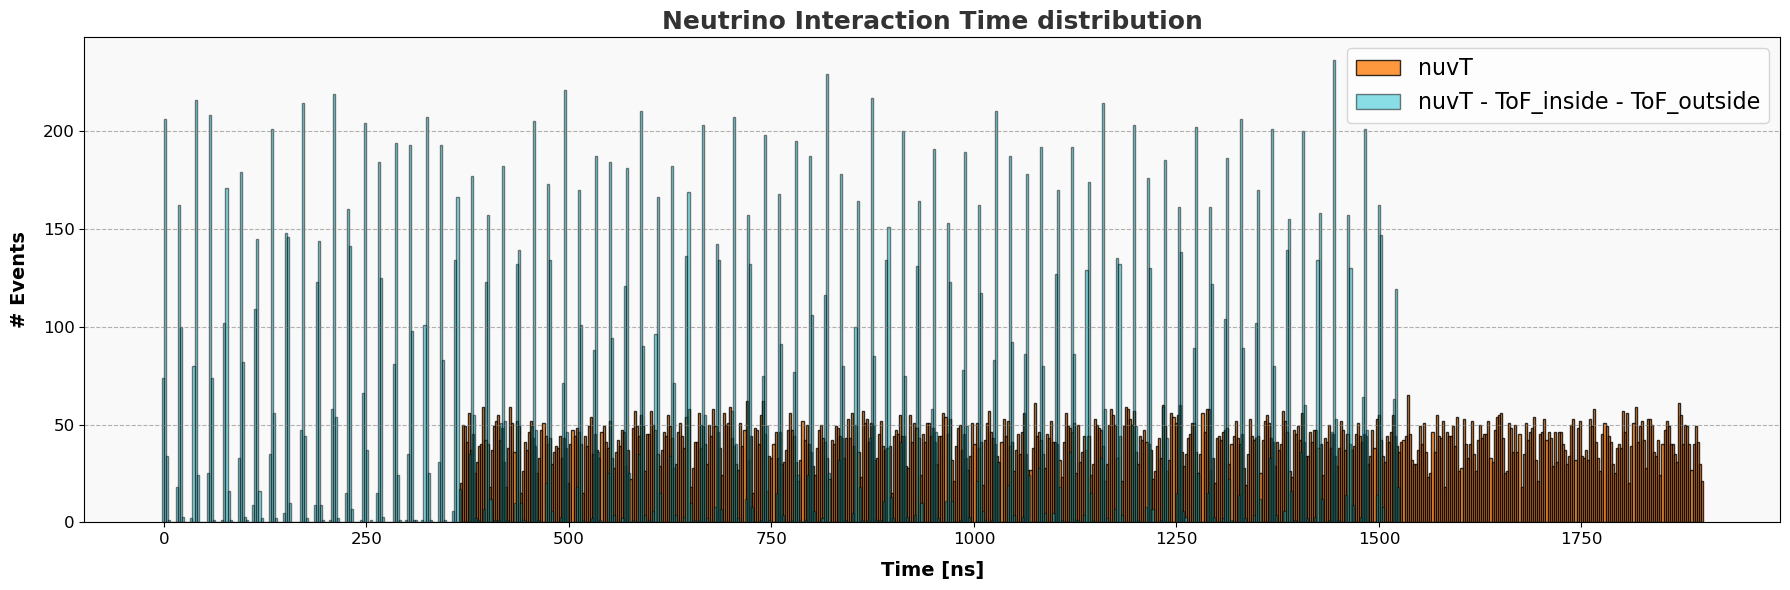

In [40]:
import matplotlib.pyplot as plt
import numpy as np
import awkward as ak

# Assuming hit_nuvT, ToF_outside_set0, and ToF_inside are defined awkward arrays
# Calculate the difference and flatten it
#difference = np.mod(ak.flatten(nuvT - ToF_inside - ToF_outside), 19)


# Calculate the standard deviation
std_dev = np.std(nuvT_3)
std_dev2 = np.std(nuvT_c + ToF_outside)

# Set up the plot
plt.figure(figsize=(18, 6))
plt.hist(nuvT_3, bins=600, color='#ff7f0e', edgecolor='black', alpha=0.8, label='nuvT')
plt.hist(nuvT_c, bins=600, color='#17becf', edgecolor='black', alpha=0.5, label='nuvT - ToF_inside - ToF_outside')

# Customize the title and labels
plt.title('Neutrino Interaction Time distribution', fontsize=18, fontweight='bold', color='#333333')
plt.xlabel('Time [ns]', fontsize=14, labelpad=10, fontweight='bold')
plt.ylabel('# Events', fontsize=14, labelpad=10, fontweight='bold')

# Set axis limits
#plt.xlim(0, 2000)
plt.ylim(0, None)

# Enhance the grid and axis appearance
plt.grid(axis='y', linestyle='--', alpha=0.6, color='gray')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Add a light background color for the plot area to add contrast
plt.gca().set_facecolor('#f9f9f9')

# Add a legend
plt.legend(fontsize=16)

# Show the plot
plt.tight_layout()
plt.show()


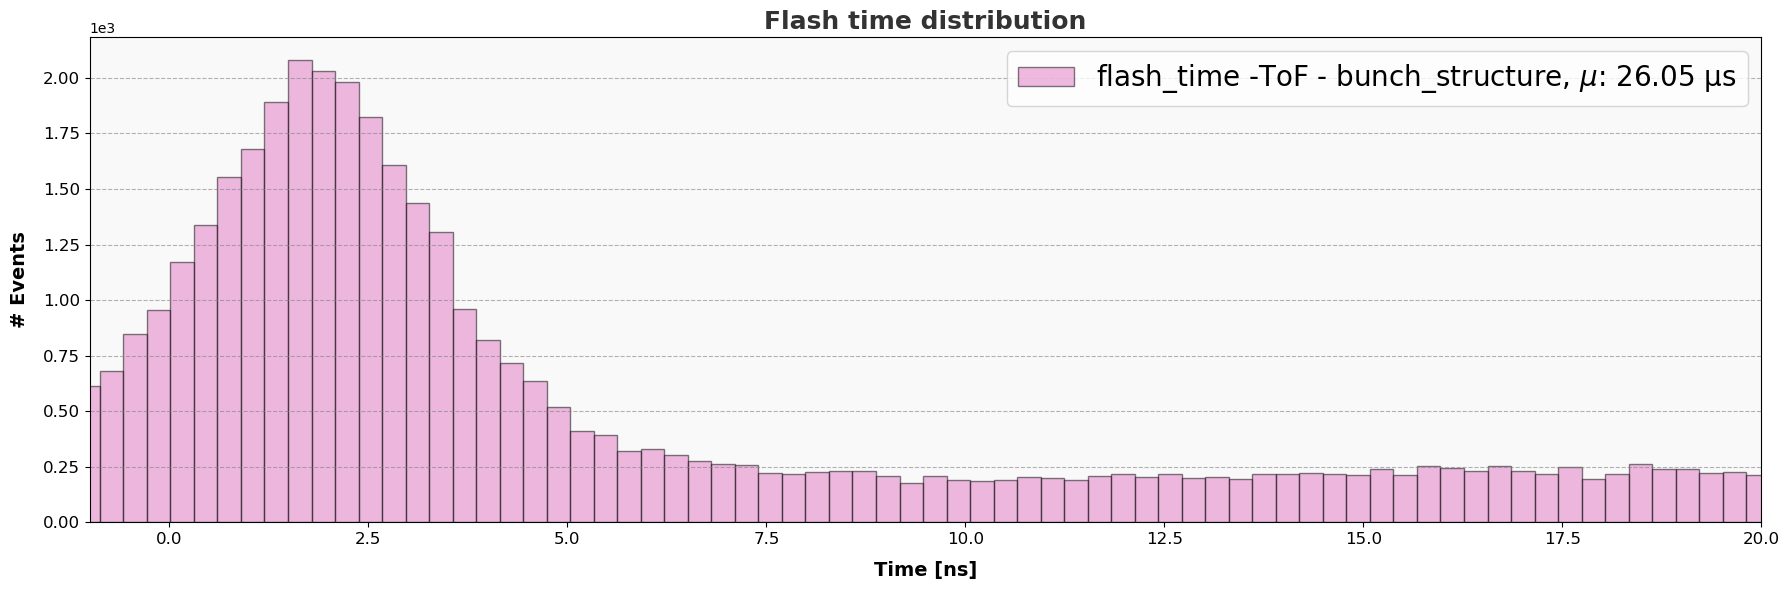

In [126]:
import matplotlib.pyplot as plt
import numpy as np
import awkward as ak

# Assuming hit_nuvT, ToF_outside_set0, and ToF_inside are defined awkward arrays

#flatten = ak.flatten(flash_time_3*1000, axis=None)
#flatten1 = ak.flatten(flash_time_c_1,axis=None)
flatten2 = ak.flatten(flash_time_c_2,axis=None)

# Calculate the standard deviation
#std_dev = np.mean(flatten)
#std_dev1 = np.mean(flatten1)
std_dev2 = np.mean(flatten2)

# Set up the plot
plt.figure(figsize=(18, 6))
#plt.hist(flatten, bins=100, color='#ff7f0e', edgecolor='black', alpha=0.8, label=f'flash_time, $\mu$: {std_dev:.2f} μs')  # Azul
#plt.hist(flatten1, bins=100, color='#17becf', edgecolor='black', alpha=0.5, label=f'flash_time - ToF, $\mu$: {std_dev1:.2f} μs')  # Verde
plt.hist(flatten2, bins=10000, color='#e377c2', edgecolor='black', alpha=0.5, label=f'flash_time -ToF - bunch_structure, $\mu$: {std_dev2:.2f} μs')  # Púrpura


# Customize the title and labels
plt.title('Flash time distribution', fontsize=18, fontweight='bold', color='#333333')
plt.xlabel('Time [ns]', fontsize=14, labelpad=10, fontweight='bold')
plt.ylabel('# Events', fontsize=14, labelpad=10, fontweight='bold')

# Set axis limits
plt.xlim(-1, 20)
plt.ylim(0, None)

# Enhance the grid and axis appearance
plt.grid(axis='y', linestyle='--', alpha=0.6, color='gray')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))  # Forces scientific notation on the y-axis

# Add a light background color for the plot area to add contrast
plt.gca().set_facecolor('#f9f9f9')

# Add a legend
plt.legend(fontsize=20)

# Show the plot
plt.tight_layout()
plt.show()


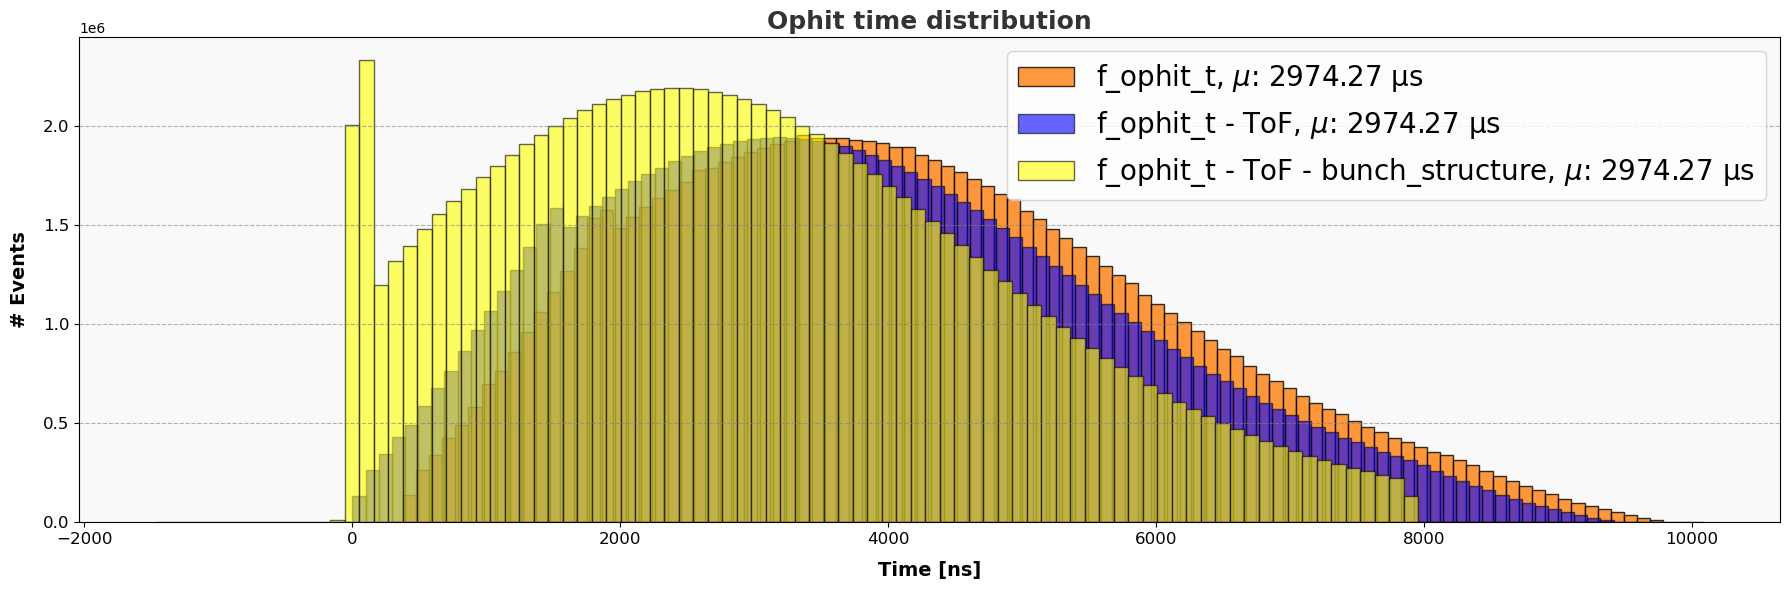

In [129]:
import matplotlib.pyplot as plt
import numpy as np
import awkward as ak

# Assuming hit_nuvT, ToF_outside_set0, and ToF_inside are defined awkward arrays

flatten = ak.flatten(f_ophit_t_3*1000, axis=None)
flatten2 = ak.flatten(f_ophit_t_c_1, axis=None)
flatten3 = ak.flatten(f_ophit_t_c_2, axis=None)

# Calculate the standard deviation
std_dev = np.mean(flatten)
std_dev = np.mean(flatten2)
std_dev = np.mean(flatten3)

# Set up the plot
plt.figure(figsize=(18, 6))
plt.hist(flatten, bins=100, color='#ff7f0e', edgecolor='black', alpha=0.8, label=f'f_ophit_t, $\mu$: {std_dev:.2f} μs')  # Azul
plt.hist(flatten2, bins=100, color='blue', edgecolor='black', alpha=0.6, label=f'f_ophit_t - ToF, $\mu$: {std_dev:.2f} μs')  # Azul
plt.hist(flatten3, bins=100, color='yellow', edgecolor='black', alpha=0.6, label=f'f_ophit_t - ToF - bunch_structure, $\mu$: {std_dev:.2f} μs')  # Azul

# Customize the title and labels
plt.title('Ophit time distribution', fontsize=18, fontweight='bold', color='#333333')
plt.xlabel('Time [ns]', fontsize=14, labelpad=10, fontweight='bold')
plt.ylabel('# Events', fontsize=14, labelpad=10, fontweight='bold')

# Set axis limits
#plt.xlim(-5, 100)
plt.ylim(0, None)

# Enhance the grid and axis appearance
plt.grid(axis='y', linestyle='--', alpha=0.6, color='gray')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))  # Forces scientific notation on the y-axis

# Add a light background color for the plot area to add contrast
plt.gca().set_facecolor('#f9f9f9')

# Add a legend
plt.legend(fontsize=20)

# Show the plot
plt.tight_layout()
plt.show()


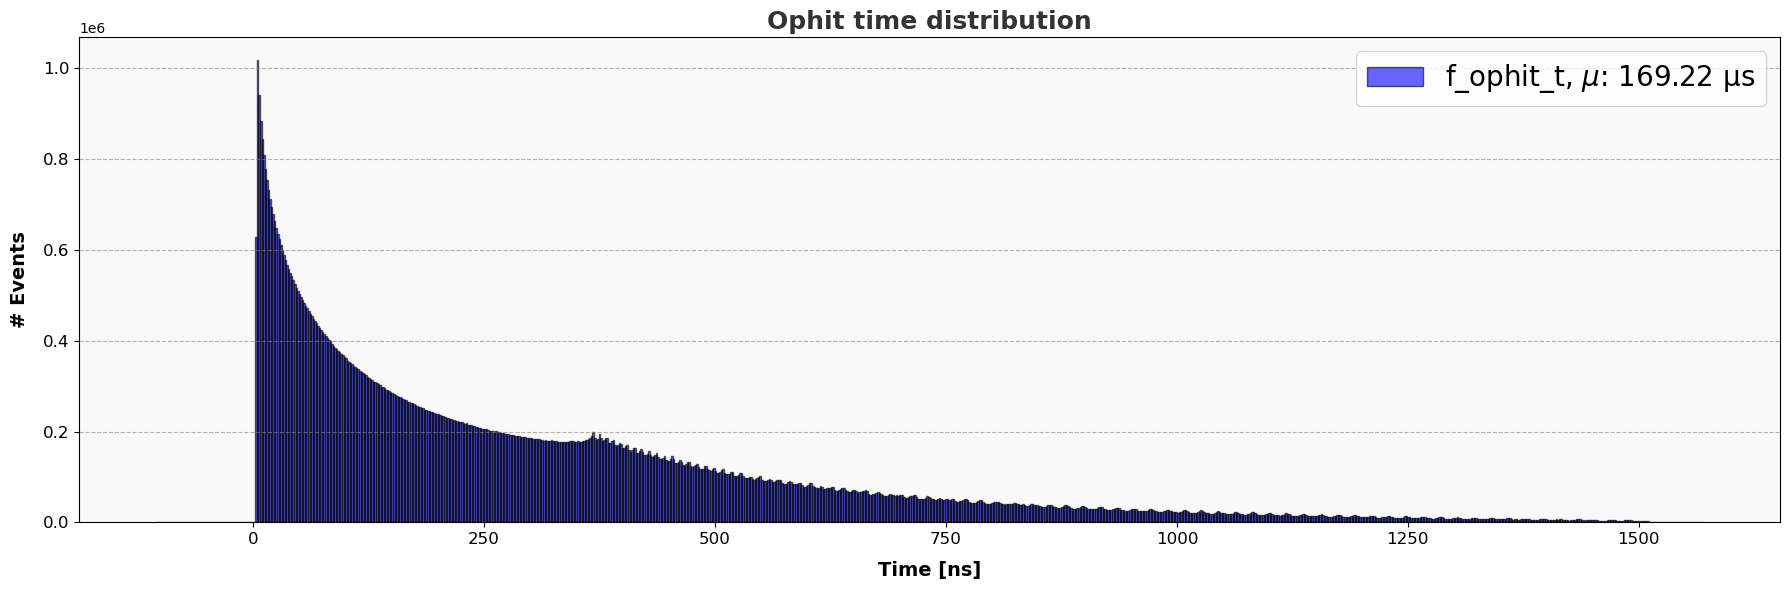

In [128]:
import matplotlib.pyplot as plt
import numpy as np
import awkward as ak

# Assuming hit_nuvT, ToF_outside_set0, and ToF_inside are defined awkward arrays


#flatten2 = ak.flatten(f_ophit_t_c_1_exp, axis=None)
flatten3 = ak.flatten(f_ophit_t_c_2_exp, axis=None)

# Calculate the standard deviation

#std_dev = np.mean(flatten2)
std_dev = np.mean(flatten3)

# Set up the plot
plt.figure(figsize=(18, 6))

plt.hist(flatten2, bins=1000, color='blue', edgecolor='black', alpha=0.6, label=f'f_ophit_t, $\mu$: {std_dev:.2f} μs')  # Azul
#plt.hist(flatten3, bins=1000, color='yellow', edgecolor='black', alpha=0.6, label=f'f_ophit_t, $\mu$: {std_dev:.2f} μs')  # Azul

# Customize the title and labels
plt.title('Ophit time distribution', fontsize=18, fontweight='bold', color='#333333')
plt.xlabel('Time [ns]', fontsize=14, labelpad=10, fontweight='bold')
plt.ylabel('# Events', fontsize=14, labelpad=10, fontweight='bold')

# Set axis limits
#plt.xlim(-5, 100)
plt.ylim(0, None)

# Enhance the grid and axis appearance
plt.grid(axis='y', linestyle='--', alpha=0.6, color='gray')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))  # Forces scientific notation on the y-axis

# Add a light background color for the plot area to add contrast
plt.gca().set_facecolor('#f9f9f9')

# Add a legend
plt.legend(fontsize=20)

# Show the plot
plt.tight_layout()
plt.show()


The BNB is created by extracting protons from the Booster accelerator at Fermilab and impacting them on a beryllium target. The time structure of the delivered proton beam consists of a series of 81 bunches, each about 1.3 ns wide and 19 ns apart, defining a spill length of 1.6 µs

## 2. PE and time matrix

**With the complete data it takes ~ 14min**

In [10]:
pe_matrix, time_matrix = process_photoelectrons(f_ophit_PE, f_ophit_ch, f_ophit_t_c_2)

In [11]:
# Save the matrices to a CSV file
np.savetxt("saved_archives/pe_matrix_&_time_matrix/pe_matrix_bunch_centered_v2701.csv", pe_matrix, delimiter=",")
np.savetxt("saved_archives/pe_matrix_&_time_matrix/time_matrix_bunch_centered_v2701.csv", time_matrix, delimiter=",")

In [12]:
# Convert awkward arrays to Arrow tables
ophit_variables_y = pa.Table.from_pydict({
    'nuvX': ak.to_list(nuvX),
    'nuvZ': ak.to_list(nuvZ),
    'nuvT_c': ak.to_list(nuvT_c),
    'nuvT_c_bunch': ak.to_list(nuvT_c_bunch),
    'dEpromx': ak.to_list(dEpromx),
    'dEpromy': ak.to_list(dEpromy),
    'dEpromz': ak.to_list(dEpromz),
    'dEtpc': ak.to_list(dEtpc)
})

# Save to Parquet file
pq.write_table(ophit_variables_y, 'saved_archives/ophit_variables_bunch_centered_v2701.parquet')